In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SQLI Detection

In [ ]:
import pandas as pd
df = pd.read_json("/content/drive/MyDrive/IAS 11/SQLiV3_clean.json")
df

,pattern,type
0,""" or pg_sleep ( __TIME__ ) --",sqli
1,create user name identified by pass123 tempora...,sqli
2,AND 1 = utl_inaddr.get_host_address ( ...,sqli
3,select * from users where id = '1' or @ @1 ...,sqli
4,"select * from users where id = 1 or 1#"" ( ...",sqli
...,...,...
30859,DELETE FROM door WHERE grow = 'small',valid
30860,DELETE FROM tomorrow,valid
30861,SELECT wide ( s ) FROM west,valid
30862,SELECT * FROM ( SELECT slide FROM breath ),valid


In [ ]:
t = [1 if i == 'sqli' else 0 for i in df.values[:,1]]
df['type'] = t
df

,pattern,type
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30859,DELETE FROM door WHERE grow = 'small',0
30860,DELETE FROM tomorrow,0
30861,SELECT wide ( s ) FROM west,0
30862,SELECT * FROM ( SELECT slide FROM breath ),0


In [ ]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
if duplicate_rows > 0:
    print(f"Warning: There are {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found in the dataset.")

df = df.drop_duplicates()

# Verify the removal of duplicate rows
duplicates_remaining = df.duplicated().sum()

# Display the status after removing duplicates
if duplicates_remaining == 0:
    print("All duplicate rows have been removed.")
else:
    print(f"Warning: {duplicates_remaining} duplicate rows still exist in the dataset.")

All duplicate rows have been removed.


In [ ]:
df['pattern'] = df['pattern'].astype(str).str.strip()  # Remove leading/trailing whitespace

empty_queries = (df['pattern'] == '').sum()

# Display the count of empty strings
if empty_queries > 0:
    print(f"Warning: There are {empty_queries} empty strings in the 'pattern' column.")
else:
    print("No empty strings found in the 'pattern' column.")

# Remove rows where the 'Query' column is empty
df = df[df['pattern'] != '']

# Verify the removal of empty strings
empty_queries_remaining = (df['pattern'] == '').sum()

# Display the status after removing empty strings
if empty_queries_remaining == 0:
    print("All empty strings in the 'pattern' column have been removed.")
else:
    print(f"Warning: {empty_queries_remaining} empty strings still exist in the 'pattern' column.")


All empty strings in the 'pattern' column have been removed.


<ipython-input-9-9a49a838806a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pattern'] = df['pattern'].astype(str).str.strip()  # Remove leading/trailing whitespace


In [ ]:
df

,pattern,type
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( (...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30859,DELETE FROM door WHERE grow = 'small',0
30860,DELETE FROM tomorrow,0
30861,SELECT wide ( s ) FROM west,0
30862,SELECT * FROM ( SELECT slide FROM breath ),0


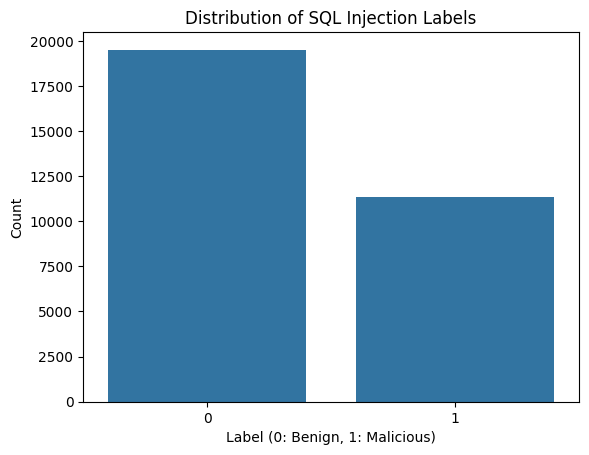

In [ ]:
#Checking Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of labels
sns.countplot(x='type', data=df)
plt.title('Distribution of SQL Injection Labels')
plt.xlabel('Label (0: Benign, 1: Malicious)')
plt.ylabel('Count')
plt.show()


In [ ]:
df[df['type'] == 1]['pattern']

,pattern
0,""" or pg_sleep ( __TIME__ ) --"
1,create user name identified by pass123 tempora...
2,AND 1 = utl_inaddr.get_host_address ( (...
3,select * from users where id = '1' or @ @1 ...
4,"select * from users where id = 1 or 1#"" ( ..."
...,...
19292,3.1E+017
19294,0x77616974666F722064656C61792027303A303A313027...
19295,â or 1 = 1 --
19296,or 'x' = 'x


In [ ]:
#Split the Dataset into Training and Testing Sets
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['pattern'], df['type'], test_size=0.2, random_state=42
)

# Display the number of samples in each set
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 24678
Testing samples: 6170


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data to TF-Isqli_df vectors
vectorizer = TfidfVectorizer(max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.4 MB/s eta 0:00:00


In [ ]:
#Define, Train, and Evaluate Classifiers
# Import required classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize classifiers with basic hyperparameters
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Evaluate each classifier
results = []

# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_tfidf)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append results
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame for easy display
results_sqli_df = pd.DataFrame(results)
results_sqli_df


,Classifier,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.946677,0.947726,0.946677,0.946106
1,Decision Tree,0.981361,0.981514,0.981361,0.981296
2,Random Forest,0.961588,0.963557,0.961588,0.961110
3,SVM,0.985737,0.985761,0.985737,0.985713
4,XGBoost,0.986710,0.986736,0.986710,0.986687


In [ ]:
classifiers['XGBoost']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# WAF

In [ ]:
import pandas as pd

sqli_df = pd.read_csv('/content/drive/MyDrive/IAS 11/clean_sql_dataset.csv')

sqli_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148326 entries, 0 to 148325
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   148326 non-null  object
 1   Label   148326 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
sqli_df.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [ ]:
# Check for missing values in the dataset
missing_values = sqli_df.isnull().sum()

# Display the count of missing values
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Query    0
Label    0
dtype: int64


In [ ]:
unique_labels = sqli_df['Label'].unique()

# Display unique values in the 'Label' column
print("Unique Values in Label Column:", unique_labels)

# Check if only binary labels (0 and 1) are present
if set(unique_labels) == {0, 1}:
    print("Dataset contains only binary labels.")
else:
    print("Dataset contains non-binary labels.")

Unique Values in Label Column: [1 0]
Dataset contains only binary labels.


In [ ]:
# Check for duplicate rows in the dataset
duplicate_rows = sqli_df.duplicated().sum()

# Display the number of duplicate rows
if duplicate_rows > 0:
    print(f"Warning: There are {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


In [ ]:
sqli_df = sqli_df.drop_duplicates()

# Verify the removal of duplicate rows
duplicates_remaining = sqli_df.duplicated().sum()

# Display the status after removing duplicates
if duplicates_remaining == 0:
    print("All duplicate rows have been removed.")
else:
    print(f"Warning: {duplicates_remaining} duplicate rows still exist in the dataset.")

All duplicate rows have been removed.


In [ ]:
sqli_df['Query'] = sqli_df['Query'].astype(str).str.strip()  # Remove leading/trailing whitespace

empty_queries = (sqli_df['Query'] == '').sum()

# Display the count of empty strings
if empty_queries > 0:
    print(f"Warning: There are {empty_queries} empty strings in the 'Query' column.")
else:
    print("No empty strings found in the 'Query' column.")

In [ ]:
# Remove rows where the 'Query' column is empty
sqli_df = sqli_df[sqli_df['Query'] != '']

# Verify the removal of empty strings
empty_queries_remaining = (sqli_df['Query'] == '').sum()

# Display the status after removing empty strings
if empty_queries_remaining == 0:
    print("All empty strings in the 'Query' column have been removed.")
else:
    print(f"Warning: {empty_queries_remaining} empty strings still exist in the 'Query' column.")


All empty strings in the 'Query' column have been removed.


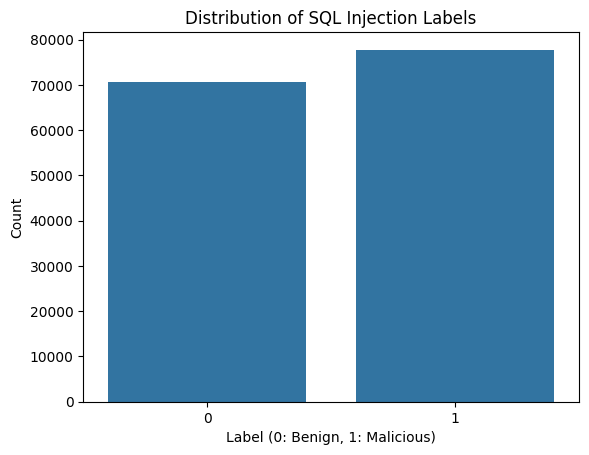

In [ ]:
#Checking Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of labels
sns.countplot(x='Label', data=sqli_df)
plt.title('Distribution of SQL Injection Labels')
plt.xlabel('Label (0: Benign, 1: Malicious)')
plt.ylabel('Count')
plt.show()


In [ ]:
#Split the Dataset into Training and Testing Sets
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    sqli_df['Query'], sqli_df['Label'], test_size=0.2, random_state=42
)

# Display the number of samples in each set
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 118659
Testing samples: 29665


In [ ]:
#Vectorize the Text Data
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data to TF-Isqli_df vectors
vectorizer = TfidfVectorizer(max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Display the shape of the TF-Isqli_df matrices
print(f"TF-Isqli_df Matrix Shape (Training): {X_train_tfidf.shape}")
print(f"TF-Isqli_df Matrix Shape (Testing): {X_test_tfidf.shape}")

TF-Isqli_df Matrix Shape (Training): (118659, 100)
TF-Isqli_df Matrix Shape (Testing): (29665, 100)


In [ ]:
results = []

# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, clf in classifiers.items():
    # Train the classifier

    # Make predictions on the test set
    y_pred = clf.predict(X_test_tfidf)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append results
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame for easy display
results_sqli_df = pd.DataFrame(results)
results_sqli_df

,Classifier,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.430069,0.407950,0.430069,0.405603
1,Decision Tree,0.372122,0.306683,0.372122,0.303896
2,Random Forest,0.286061,0.257259,0.286061,0.260140
3,SVM,0.411832,0.387055,0.411832,0.387122
4,XGBoost,0.297219,0.297822,0.297219,0.296134


In [ ]:
#Define, Train, and Evaluate Classifiers
# Import required classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize classifiers with basic hyperparameters
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Evaluate each classifier
results = []

# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_tfidf)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append results
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame for easy display
results_sqli_df = pd.DataFrame(results)
results_sqli_df


,Classifier,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.802090,0.807068,0.802090,0.800430
1,Decision Tree,0.944986,0.947594,0.944986,0.945003
2,Random Forest,0.941514,0.943267,0.941514,0.941541
3,SVM,0.905141,0.909842,0.905141,0.905114
4,XGBoost,0.949469,0.951698,0.949469,0.949489


In [ ]:
#Cross-Validation for Consistency
# Import cross-validation
from sklearn.model_selection import cross_val_score

# Add cross-validation results to the table
for result in results:
    clf = classifiers[result['Classifier']]
    cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=5, scoring='f1_weighted')
    result['CV F1-Score'] = cv_scores.mean()

# Update results DataFrame
results_sqli_df = pd.DataFrame(results)
results_sqli_df


,Classifier,Accuracy,Precision,Recall,F1-Score,CV F1-Score
0,Naive Bayes,0.802090,0.807068,0.802090,0.800430,0.801471
1,Decision Tree,0.944986,0.947594,0.944986,0.945003,0.945544
2,Random Forest,0.941514,0.943267,0.941514,0.941541,0.941370
3,SVM,0.905141,0.909842,0.905141,0.905114,0.907772
4,XGBoost,0.949469,0.951698,0.949469,0.949489,0.950750


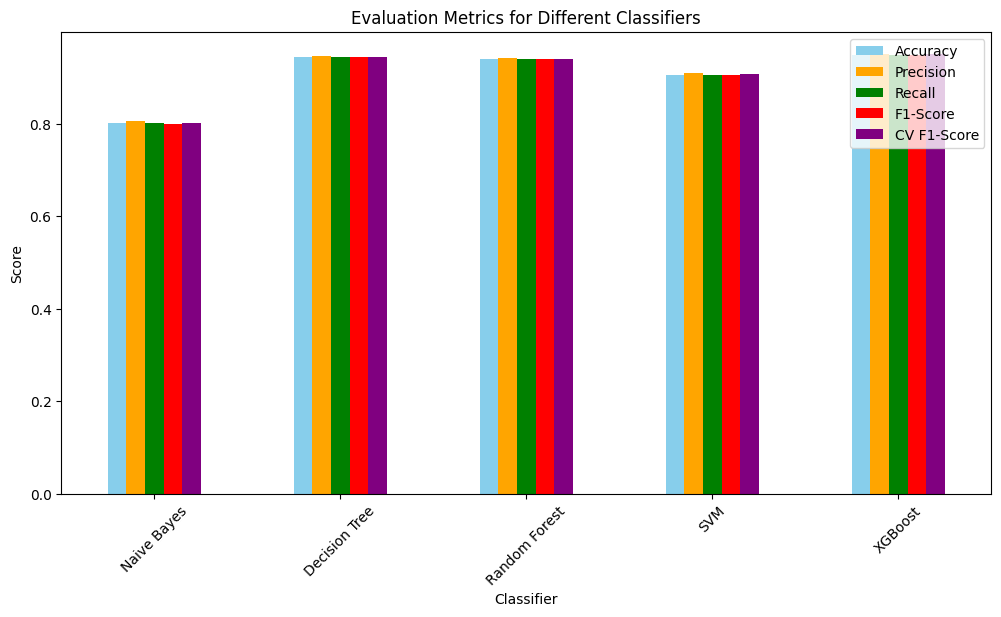

In [ ]:
# Visualize Results
import matplotlib.pyplot as plt

# Plotting the evaluation metrics for comparison
results_sqli_df.set_index('Classifier')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV F1-Score']].plot(
    kind='bar', figsize=(12, 6), color=['skyblue', 'orange', 'green', 'red', 'purple']
)
plt.title("Evaluation Metrics for Different Classifiers")
plt.ylabel("Score")
plt.xlabel("Classifier")
plt.xticks(rotation=45)
plt.show()
